# Intro
10: Stable Diffusion 2

# Lesson Overview
This lesson recapped conceptually how stable diffusion works, what it is, how classifier free diffusion works, and how three research papers modify it uniquely. Then there is a notebook going through how stable diffusion is implemented in HuggingFace's pipeline, as well as the first notebook of a series to recreate stable diffusion and fast.ai from scratch. 

I found the lesson both conceptually difficult and time consuming but very interesting. My understanding of how stable diffusion works and how to implement it has improved greatly.

# Lecture Notes

We start with a recap of how the core components of stable diffusion works. <br>
There are three of them: The unet, CLIP, and VAE.

# unet
The unet knows how to find the noise (the parts of the image that don't represent its label) in an image.

We train it to do so by adding noise using a scheduler to images, then giving the unet the noisy image and getting it to predict what parts are the noise.

## For example, for handwritten digits:
- 7 + Noise = Noisy 7. 
- Give Noisy 7 to unet, and unet predicts the Noise. 
- It then compares its prediction to the actual noise to get a loss to improve itself. 
- To make the unet work better, we pass in a label: an embedding of 7. For example, we could enter a one-hot encoded vector of it. 
- If we do this, then later on we can get the unet to create 7 of us because it understands what the embeddings of 7 are.

# CLIP

But we don't want our unet to create handwritten digits, we want to create images, and embeddings for them cannot be one-hot encoded.

So we use CLIP to create embeddings for prompts, so we can enter an image into our unet with an embedding of its prompt, similar to how we previous entered a handwritten digit image with an embedding of its number.

CLIP consists of two parts: An image encoder and an text encoder.

## To train these encoders: 
- Firstly we find images online that are captioned (has a prompt).
- We input an image into the image encoder, and this produces embeddings (a feature vector) of the image.
- We input the image's prompt into the text encoder, and this produces embeddings (a feature vector) of the prompt. 
- We then train both to get these two sets of embeddings to be the same.
- This is done with contrastive loss: prioritising these two sets of embeddings to be the same for when an image and prompt match, and penalising when they don't.  

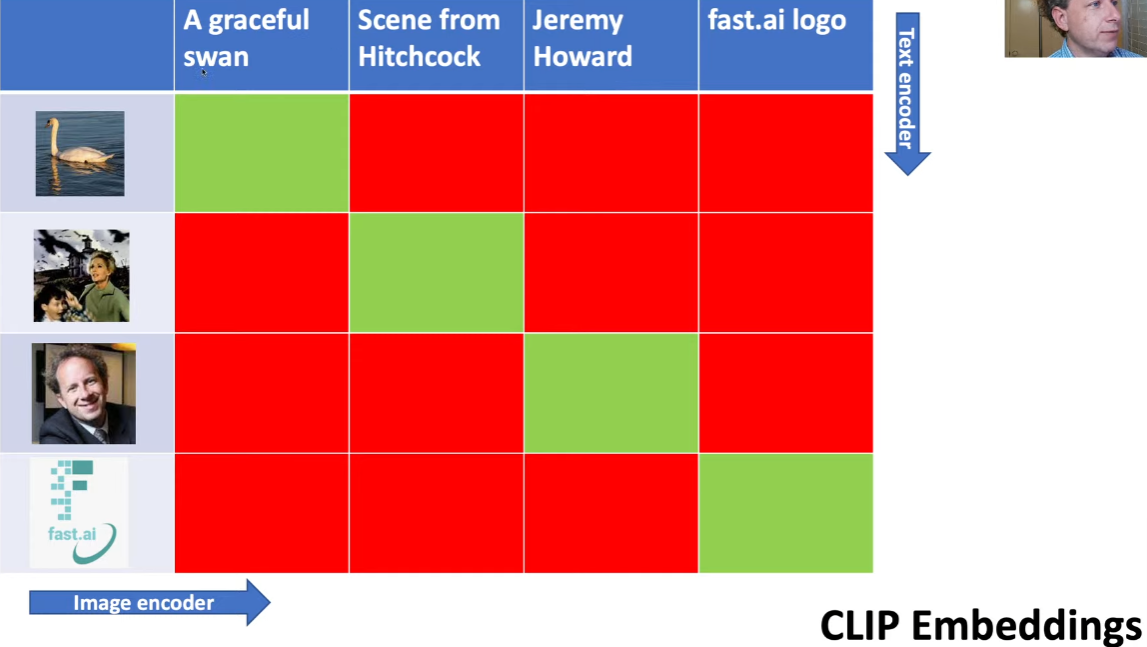

Both encoders now can produce embeddings, but we only care about the text encoder. It can take prompts of images and create embeddings for them. With this, we can input into our unet both an image and (an embedding of) its prompt!

# Inference (Image Creation)
Inference is the process of creating an image from a prompt. It's also called denoising.

First we input into the unet a image of pure (Gaussian) noise and a prompt of the image we want.

The unet then predicts what parts of that image is noise. This actually means it thinks "which pixels from the image should I remove to get the image to look more like the prompt?".

We could now just remove all the predicted noise in one go, but this would result in an awful image. Instead, we take the predicted noise and only remove some of it. This creates a less noisy image.

We then put our less noisy image back into our unet and repeat the process to remove more noise. Then we repeat this until we end up with our final image. Each time we remove noise is called a step. Previously it took about 60 steps to create an image, but a new paper described a method to do it in 3-4.

The diagram below shows how the image is gradually created as the steps occur:

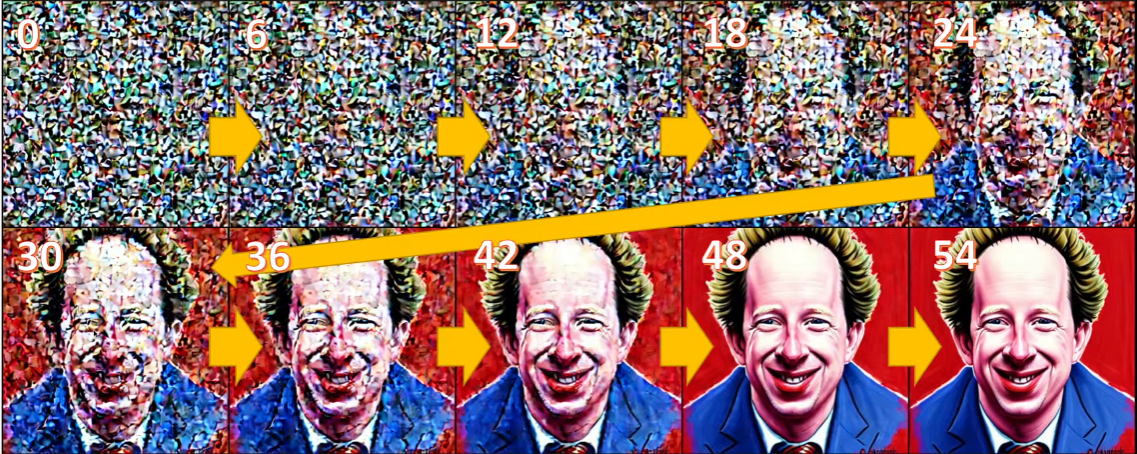

# VAE

Using a VAE and latent images is a computational shortcut to do stable diffusion much faster.

When we trained our unet, we implicitly used full sized images to do so, but this is really computationally expensive!
A standard 512x512x3 image is 786432 px, which is too many to compute. 

We can compress images though, while retaining the information needed to recreate them. To do so, we put the image through two convolutional layers and get a 64x64x24 image, with 16384 pixels, 48x less than the original!
To reconstruct the image, we simply put it through two inverse convolutional layers.

We call the compression part an encoder, and the reconstruction part a decoder. Both combined are called an autoencoder, but in the case of stable diffusion we call an autoencoder a VAE.
We call the compressed images, latents. 

With this in mind, we create latents using the VAE's encoder. <br>
Now we train our unet on latents instead of full sized images, and do the inference process with latents too. <br>
When our fully denoised latent is created, we simply use the decoder to reconstruct it to full size.

# What is Stable Diffusion?

General diffusion models are machine learning systems that are trained to denoise (do inference) in steps on random Gaussian noise to create a sample of interest such as images.

The difference between general diffusion models and latent diffusion models is that the latter generates and uses latent (compressed) representations of images. This reduces the memory and computational needs significantly. The difference is an autoencoder (vae), which can reduce memory usage by 48 times for a 512x512 image as (3,512,512) becomes (4,64,64) in latent space.
In effect, this speeds up both training and denoising significantly.

Stable Diffusion is based on latent diffusion. It was proposed in a paper High-Resolution Image Synthesis with Latent Diffusion Models at https://arxiv.org/abs/2112.10752.

# Research Papers

## Progressive Distillation for Fast Sampling of Diffusion Models:

Looking at the inference process, we can reduce the steps to denoise an image using distillation.
Distillation is a pretty common technique in deep learning.

Look at step 36 and step 54 of inference below:

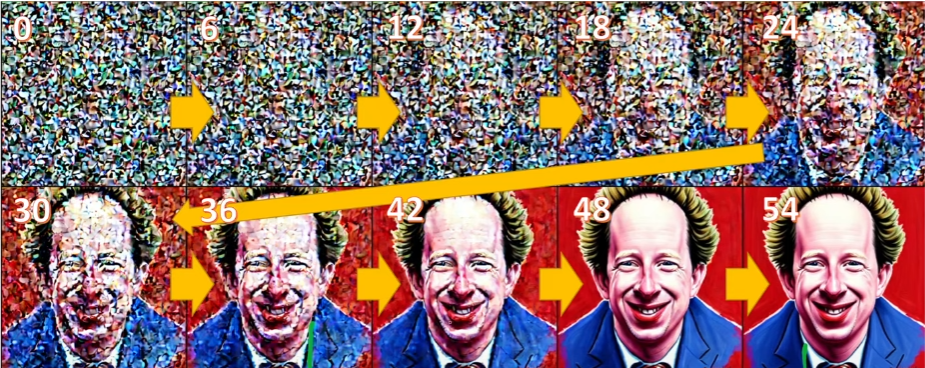

Why is step 36 to 54 taking a whole 18 steps when there's not much left to do comparatively to step 0 to 18 for instance?

The reason is, it takes very long because of a side effect of how the original maths of stable diffusion works. 

But the thing is, after each step, we have an output image to play with! (we only plotted the output images every 6 steps). 

What if we used a new model, unet B. unet B can take the output of step 36, and try to create the output of step 54. We can then compare the two to train unet B to learn how to get from step 36 to step 54 directly!

We have a teacher network (it already knows how to do something, but is slow and big), and a student network (it tries to do the same as the teacher but faster and with less memory). 

Our teacher model is the original complete stable diffusion model. Our student model is the unet B skipping steps. 

Generally speaking, we start with a noisy latent and the teacher model denoises it for 2 steps (it doesn't create an image in 2 steps, just does 2 steps). Our student model then learns how to take the noisy latent and do the teacher's 2 step denoising in 1 step. <br> 
Then we get the starting noisy latent and get the student model to denoise it for 2 steps. <br>
And make another student learn how to do 2 steps of this in 1 step.

The original teacher model did some denoising in 2 steps. The first student could do that denoising in 1 step, so 2 steps of it would result in 4 of the original. The second student does the first's in 1 step, so 2 steps of it results in 8 of the original. And so on, I suppose until you end up with 3-4 steps being enough to generate an image!

## On Distillation of Guided Diffusion Models Paper

### Classifier-free guided diffusion models (CFGD)

Classifier-free guided diffusion models (CFGD) is a technique to control how strongly our output image matches our prompt. <br>

Say we want to create a photo of a cute puppy.
We put "a cute puppy" into CLIP (its text_encoder) to get an embedding of the prompt.
We then put this embedding into our unet with a pure noise latent to generate our puppy picture for us.
This is normally how we do stable diffusion, but CFGD allows us to control how strongly this generated image matches our cute puppy prompt.

Here's how it works:
Put an empty "" prompt into CLIP too to get another embedding. This embedding is particular because it represents nothing. If we did inference just on this, we would essentially be telling our unet "generate an image without any guidance, no restrictions, as long as it looks good". 

Instead, we concatenate the 'a cute puppy' prompt embeddings with the blank "" prompt embeddings, and put them into our unet with a pure noisy latent.
The unet outputs an image representing the real prompt, and another image representing the fake prompt. We combine these two images together. 
(**I don't understand why the unet produces 2 images, shouldn't it just produce 1 image of them combined in the first place? That's how the notebook code did it**)

To recap, we just did the first step of inference, we took a noisy latent and removed a bit of noise to make it look more the embedding of the prompt "a cute puppy" concatenated with the embeddings of the prompt "". 

We then go onto doing inference as normal, removing noise step by step until we get our final image. The point of this is that, we can control how much the final image should rely on the real prompt versus the blank one. The latter is high guidance, the former is less. This allows us to control how strictly the real prompt is followed.

### The Paper

This way of doing CFGD is awkward because the unet has to output two images instead of the usual one, and for other reasons. The paper details a way to skip it. We do teacher student distillation again!

Our normal stable diffusion with CFGD is the teacher model. It does CFGD with a number of different levels of guidance, 2, 4, 5, 12 etc.
It does inference by starting with a noisy latent, then creating an image with guidance introduced. 
Our student model is another unet, unet B. Very similarly to how it worked in the previous paper, it looks at the different step outputs created by the teacher model, and learns how to do guidance like the teacher, but in a much more less awkward way. 

There is an extra video on this, walking through the paper. It's useful to watch this to learn how to read papers properly, as in, what's important and such, in particular, the most important part is usually the algorithm.  

## Imagic: Text-Based Real Image Editing with Diffusion Models

This is another paper that just came out 3 hours ago as of writing!

Give it an input image, and pass in a prompt. It tries to edit the input image to match the prompt. 

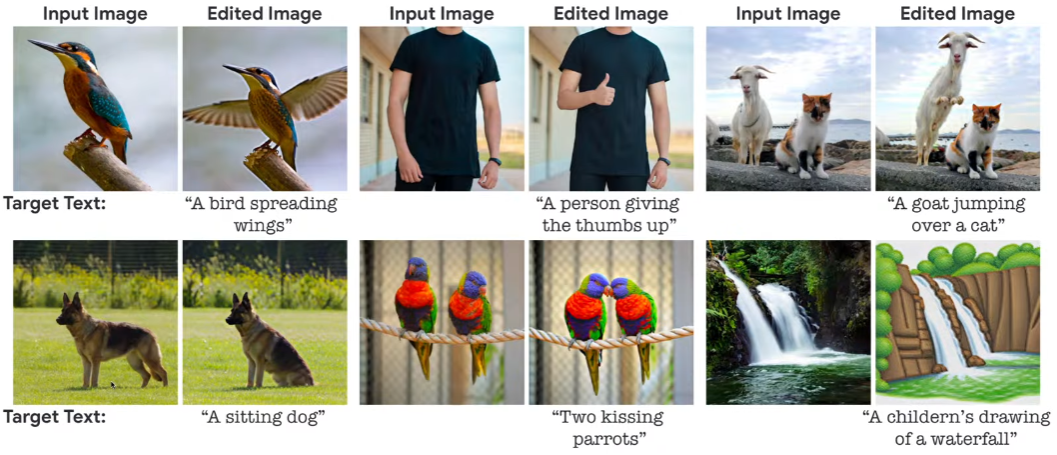

This paper is for imagen, a different image generation algorithm, but it also works fine for stable diffusion.

Generally speaking, it works through fine-tuning and optimising embeddings. 

We start with a fully trained stable diffusion model.

Our input image is 

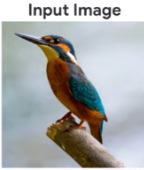

We want an image of it spreading its wings.

Use CLIP to get an embedding of our prompt "a bird spreading its wings". Use this embedding for inference as usual. This will create a photo of a bird spreading its wings, but not a photo of the bird from out input image spreading its wings. 

To remedy this, we fine tune the prompt embedding to try and get it to create an image similar to the input bird image. We only do this a little and lock it, it cannot change any more. Now we have  an optimised embedding.

Now we fine tune the entire stable diffusion model to generate images that look like our bird from the input image. Now we have a fine-tuned diffusion model.

Finally, we combine the optimised embedding and the original embedding for our target prompt, and pass it through the fine-tuned diffusion model to create our output image!

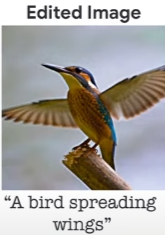

Maybe it would only take like an hour to do this process using stable diffusion on GPUs!

# Notebook: Stable Diffusion with Diffusers: Looking inside the Pipeline

Jeremy goes through the notebook: stable_diffusion.ipynb, available on a GitHub depository. 
I watched his walkthrough, made notes, then cloned the notebook and ran through it while commenting. This was a great learning experience, and made my understanding of the concepts much more solid.

There is a useful function, latents_callback, that shows a diagram of the images getting less noisy over time during inference.

For example:

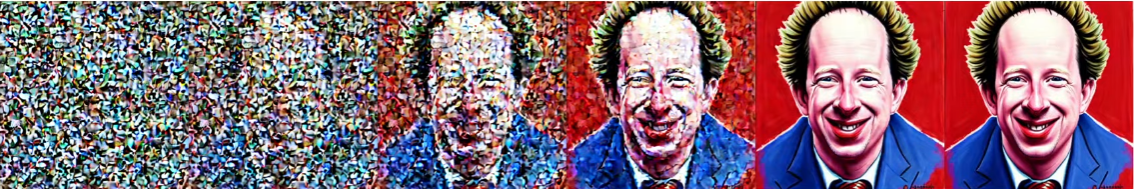

Because latents_callback is a parameter in pipeline, to use it I need to know how to create a pipeline out of it's components, which I have not yet covered.

# Notebook: Matrix Multiplication from foundations

Now what we're going to do is rebuild all of these functions from scratch. We're going to learn how to create a framework from some foundations and this will help with implementing new research papers, advanced debugging, and learning how to use Python!

## Our foundations are:
- Python
- Matplotlib
- The Python Standard Libary
- Jupyter Notebooks and nbdev

To be clear, after we have created a function, we're allowed to use a module to do it. For example, we don't start with Numpy arrays, but after we've made our own we can use them. 

This is also how machine learning models will work. We cannot train full models on our own, so we will create and train small models, and then allow ourselves to use pretrained models online.

This is a challenge that will be different, but it's often the part of the course where people learn the most. This year around it will be the best to date, and is more than worth doing.

The notebooks are from the part 2 repo on GitHub.

## Useful Shortcuts and Tools

- Shift-m in Jupyter allows you to combine cells together.
- Cntrl-shirt-minus allows you to separate them. 
- Alt-enter inserts cells.
- Run a function then ? to get a brief description.
- Run a function then ?? to get documentation.
- Inside a function, press shift-tab to see parameters available quickly. 

## Advice

- Read the Python documentation a lot, it's good.
- For every single method, Jeremy reads the documentation and practices it.

## Notes
I made notes on the lecture, then went through the notebook myself and rewrote the notes while running through and testing the cells. 

# Links
- As I am doing this lesson as it is released privately live, I cannot share links to the resources.